In [1]:
# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

# some vectorizers
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# imports for creating a baseline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import json
import torch
import torch.nn as nn

%matplotlib inline

In [2]:
# functions for preprocessing
def clean_text(text):
    # turn text to lowercase
    text = text.lower()
    
    # remove all characters that are not letters or whitespace
    text = re.sub(r'[^\p{L} ]', '', text)
    
    return text

In [3]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions_altered.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
        
# remove labels that have less than m occurrences
m = 0

labels_list = df['confirmed'].tolist()
labels_list = sum(labels_list, [])
c = Counter(labels_list)
for i in range(len(df)):
    to_remove = []
    
    # find labels that should be removed 
    for j in range(len(df['confirmed'][i])):
        if c[df['confirmed'][i][j]] < m:
            to_remove.append(j)
            
    # remove the labels
    shift = 0
    for j in range(len(to_remove)):
        df['confirmed'][i].pop(to_remove[j]-shift)
        shift += 1
    
        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# remove all rows with no confirmed labels
df = df[df['confirmed'].map(len) > 0]
df = df.reset_index(drop=True)

In [4]:
df.head()

,text,confirmed,suggested,labels
0,Slut på medicin.,"[89, 651]",[348],"[Känd astma, Känd lungsjukdom]"
1,Behöver att prata med psykolog angående använd...,"[116, 215]","[215, 348, 446]","[Nedstämdhet, Trötthet]"
2,Har fått besvärlig eksem på händerna,"[2, 141]",[141],"[Hudbesvär, Synliga hudbesvär]"
3,Muskelsvaghet och trötthet känner mig skakig o...,"[606, 215]","[12, 97, 215, 359, 518, 606]","[Muskelsvaghet, Trötthet]"
4,Svår smärta i vänsterhanden/handleden precis n...,"[682, 493]","[15, 28, 48, 54, 114, 148, 246, 313, 333, 339,...","[Smärta i handled eller fingrar, Förvärras av ..."


In [5]:
# create X matrix
texts = df['text'].tolist()

for i in range(len(texts)):
    texts[i] = clean_text(texts[i])
    
v = TfidfVectorizer(ngram_range=(1,5), max_features=5000)
X = v.fit_transform(texts).todense()

# check number of unigrams, bigrams, trigrams, etc
voc = v.vocabulary_
ngram_counts = [0 for i in range(10)]
for v in voc:
     ngram_counts[len(v.split())-1] += 1
    
print(ngram_counts)

[1620, 2280, 784, 225, 91, 0, 0, 0, 0, 0]


In [6]:
# create y matrix (labels)
labels = df['labels'].tolist()

multilab_bin = MultiLabelBinarizer()
y = multilab_bin.fit_transform(labels)

In [7]:
# turn X and y into tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# matrix info
x_nnz = torch.count_nonzero(X)
y_nnz = torch.count_nonzero(y)

print(f'X: {X.shape[0]} x {X.shape[1]} matrix\t | {(x_nnz / (X.shape[0]*X.shape[1])) * 100:.3f} % nonzero elements')
print(f'y: {y.shape[0]} x {y.shape[1]} matrix\t | {(y_nnz / (y.shape[0]*y.shape[1])) * 100:.3f} % nonzero elements')

X: 3777 x 5000 matrix	 | 0.547 % nonzero elements
y: 3777 x 197 matrix	 | 1.018 % nonzero elements


In [8]:
# define the NN

# single-layered NN
class Net_1(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net_1, self).__init__()
        self.fc1 = nn.Linear(D_in, H1)
        self.fc2 = nn.Linear(H1, D_out)
        self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigm(x)
        return x

# multi-layered NN
class Net_m(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net_m, self).__init__()
        self.fc1 = nn.Linear(D_in, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, H3)
        self.fc4 = nn.Linear(H3, D_out)
        self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigm(self.fc4(x))
        return x

In [9]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1


In [10]:
# prepare the data for the training and test
batch_size = 128

# add a column in y that keeps track of the index of the corresponding text
# make sure to handle it later
y_temp = torch.cat((torch.tensor([i for i in range(y.shape[0])]).view(-1,1), y),1)

X_train, X_test, y_train, y_test = train_test_split(X, y_temp,
                                                    random_state=42,
                                                    test_size=0.2,
                                                    shuffle=True)

# create datasets. (do not include the index added above in y)
train_set = torch.utils.data.TensorDataset(X_train, y_train[:,1:])
test_set = torch.utils.data.TensorDataset(X_test, y_test[:,1:])

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size,
                                          shuffle=True
                                          )
# might be unnecessary to use a loader for the test set right now
test_loader = torch.utils.data.DataLoader(dataset=train_set,
                                         batch_size=batch_size,
                                         shuffle=True)

# define weights for the BCELoss function to combat the imbalanced dataset
# NOTE: using this choice of weights seemed to improve performance but I think that this way may be wrong
#label_counts = np.sum(y.numpy(), axis=0)
#weight = torch.tensor(label_counts)

In [11]:
# define the model
D_in, H1, H2, H3, D_out = X.shape[1], 5000, 2000, 2000, y.shape[1]

model = Net_1(D_in, H1, D_out)
#model = Net_m(D_in, H1, H2, H3, D_out)
model = model.to(device)


# training loop
learning_rate = 0.0003

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# same as criterion except that it is guaranteed to work with matrices on cpu
criterion_cpu = torch.nn.BCELoss()

# losses over entire train-/test-set per epoch
train_losses = []
test_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # save the losses
    model = model.to(torch.device('cpu'))
    
    y_pred_train = model(X_train)
    temp_loss = criterion_cpu(y_pred_train, y_train[:,1:])
    train_losses.append(temp_loss)
    
    y_pred_test = model(X_test)
    temp_loss = criterion_cpu(y_pred_test, y_test[:,1:])
    test_losses.append(temp_loss)
    
    model = model.to(device)
    
    
    
    print(f'End of epoch {epoch+1}, Train Loss: {train_losses[-1]:.7f}, Test Loss: {test_losses[-1]:.7f}')

End of epoch 1, Train Loss: 0.3636146, Test Loss: 0.3644429
End of epoch 2, Train Loss: 0.0900377, Test Loss: 0.0906369
End of epoch 3, Train Loss: 0.0593005, Test Loss: 0.0608403
End of epoch 4, Train Loss: 0.0525399, Test Loss: 0.0543743
End of epoch 5, Train Loss: 0.0494071, Test Loss: 0.0514172
End of epoch 6, Train Loss: 0.0471570, Test Loss: 0.0492759
End of epoch 7, Train Loss: 0.0452678, Test Loss: 0.0474915
End of epoch 8, Train Loss: 0.0434354, Test Loss: 0.0459040
End of epoch 9, Train Loss: 0.0416382, Test Loss: 0.0443696
End of epoch 10, Train Loss: 0.0398651, Test Loss: 0.0428377
End of epoch 11, Train Loss: 0.0381247, Test Loss: 0.0413611
End of epoch 12, Train Loss: 0.0365080, Test Loss: 0.0400431
End of epoch 13, Train Loss: 0.0350479, Test Loss: 0.0388245
End of epoch 14, Train Loss: 0.0337278, Test Loss: 0.0377735
End of epoch 15, Train Loss: 0.0325434, Test Loss: 0.0368529
End of epoch 16, Train Loss: 0.0314450, Test Loss: 0.0360268
End of epoch 17, Train Loss: 0.03

Micro-average F1-score: 0.49011857707509887
Weighted-average F1-score: 0.372282938233623
Macro-average F1-score: 0.3562315478607492
Sample-average Jaccard score: 0.34114438985470724
Accuracy (exact match): 0.20238095238095238
Hamming Loss: 0.00866167109821932


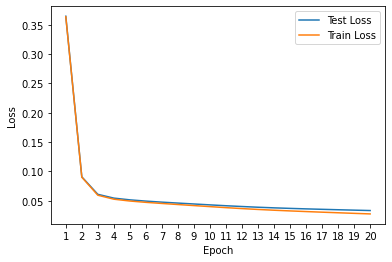

In [12]:
model = model.to(torch.device('cpu'))
y_pred = model(X_test).detach().numpy()

# set all values above threshold to 1, else 0
th = 0.2
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

print(f"Micro-average F1-score: {f1_score(y_test[:,1:], y_pred, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_test[:,1:], y_pred, average='weighted', zero_division=1)}")
print(f"Macro-average F1-score: {f1_score(y_test[:,1:], y_pred, average='macro', zero_division=1)}")
print(f"Sample-average Jaccard score: {jaccard_score(y_test[:,1:], y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_test[:,1:], y_pred)}")
print(f"Hamming Loss: {hamming_loss(y_test[:,1:], y_pred)}")

x = [x for x in range(1,num_epochs+1)]
plt.plot(x, test_losses)
plt.plot(x, train_losses)
plt.legend(['Test Loss', 'Train Loss'])
plt.xticks(x, x)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.gca().set_ylim([0,0.1])
plt.show()

In [ ]:
# print confusion matrices for each class
mlcm = multilabel_confusion_matrix(y_test[:,1:], y_pred)
classes = multilab_bin.classes_
for i in range(len(classes)):
    print(classes[i])
    print(mlcm[i])
    print()

In [14]:
# find the 'per' % best/worst samples in the test-set w.r.t. BCE-loss
per = 20

loss_sorted = []

for i in range(y_test.shape[0]):
    y_pred = model(X_test[i,:])
    y_pred = y_pred.detach()
    loss = criterion_cpu(y_pred, y_test[i,1:])
    loss_sorted.append((loss, y_pred, y_test[i,:]))
    
loss_sorted = sorted(loss_sorted, key=lambda tup: tup[0])

nbr_elems = (len(loss_sorted) * per) // 100
min_loss = loss_sorted[:nbr_elems]
max_loss = loss_sorted[len(loss_sorted)-nbr_elems:]

# TODO: check which labels are present in the test- and train-set
#       to determine whether the model should be able to predict it

In [ ]:
# print the top 'per' % best samples
for i in range(len(min_loss)):
    loss, y_pred, y_test_row = min_loss[i]
    
    # turn y_pred into binary (threshold th defined above)
    y_pred[y_pred > th] = 1
    y_pred[y_pred <= th] = 0
    
    y_pred_syms = multilab_bin.inverse_transform(y_pred.view(1,-1))
    y_test_syms = multilab_bin.inverse_transform(y_test_row[1:].view(1,-1))
    
    print(f'Loss: {loss}')
    print(f'{df["text"][int(y_test_row[0])]}')
    print(f'Prediction:\t {y_pred_syms}')
    print(f'Labels:\t\t {y_test_syms}')
    print('- - - - - - - - - - - - - -')

In [ ]:
# print the top 'per' % worst samples
for i in range(len(max_loss)):
    loss, y_pred, y_test_row = max_loss[i]
    
    # turn y_pred into binary (threshold th defined above)
    y_pred[y_pred > th] = 1
    y_pred[y_pred <= th] = 0
    
    y_pred_syms = multilab_bin.inverse_transform(y_pred.view(1,-1))
    y_test_syms = multilab_bin.inverse_transform(y_test_row[1:].view(1,-1))
    
    print(f'Loss: {loss}')
    print(f'{df["text"][int(y_test_row[0])]}')
    print(f'Prediction:\t {y_pred_syms}')
    print(f'Labels:\t\t {y_test_syms}')
    print('- - - - - - - - - - - - - -')

In [17]:
# simple classifier used as a baseline
#clf = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
#clf.fit(X_train, y_train[:,1:])

In [18]:
if False:
    y_pred_test_bl = clf.predict(X_test)
    y_pred_train_bl = clf.predict(X_train)

    bl_test_loss = criterion(torch.tensor(y_pred_test_bl, dtype=torch.float), y_test[:,1:])
    bl_train_loss = criterion(torch.tensor(y_pred_train_bl, dtype=torch.float), y_train[:,1:])

    print("Baseline metrics")
    print(f"Micro-average F1-score for baseline: {f1_score(y_test[:,1:], y_pred_test_bl, average='micro')}")
    print(f"Sample-average Jaccard score: {jaccard_score(y_test[:,1:], y_pred_test_bl, average='samples', zero_division=1)}")
    print(f"Accuracy (exact match): {accuracy_score(y_test[:,1:], y_pred_test_bl)}")
    print(f"Hamming Loss: {hamming_loss(y_test[:,1:], y_pred_test_bl)}")

    x = [x for x in range(1,num_epochs+1)]
    plt.plot(x, test_losses)
    plt.plot(x, train_losses)
    plt.plot(x, [bl_test_loss for i in range(len(x))])
    plt.plot(x, [bl_train_loss for i in range(len(x))])
    plt.legend(['Test Loss', 'Train Loss', 'Test Loss Baseline', 'Train Loss Baseline'])
    plt.xticks(x, x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.gca().set_ylim([0,0.1])
    plt.show()